In [190]:
#--- Transform, clean data ---#
import pandas as pd
import numpy as np
#--- Manage Missing values ---#
import missingno as msno

#--- Data visualisation ---#
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

#--- Data pre processing ---#
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#--- Machine learning model : Logistic regression ---#
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#--- Metrics ---#
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [191]:
# Importer les données
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [192]:
#df.head()

### Exploratory data analysis ( EDA )

- Le jeu de donnée est composé de 5110 observations avec 12 variables
- Les variables sont de type numériques et catégorielles
- Il y a la présence de valeur manquantes en particulier dans la colonne bmi

In [193]:
df.shape

(5110, 12)

. Dimension du dataset qui est constitué de 5110 obervations et 12 variables

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


. Les variables sont de type int, float et object

In [195]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

. Il y a des valeurs manquantes

<AxesSubplot:>

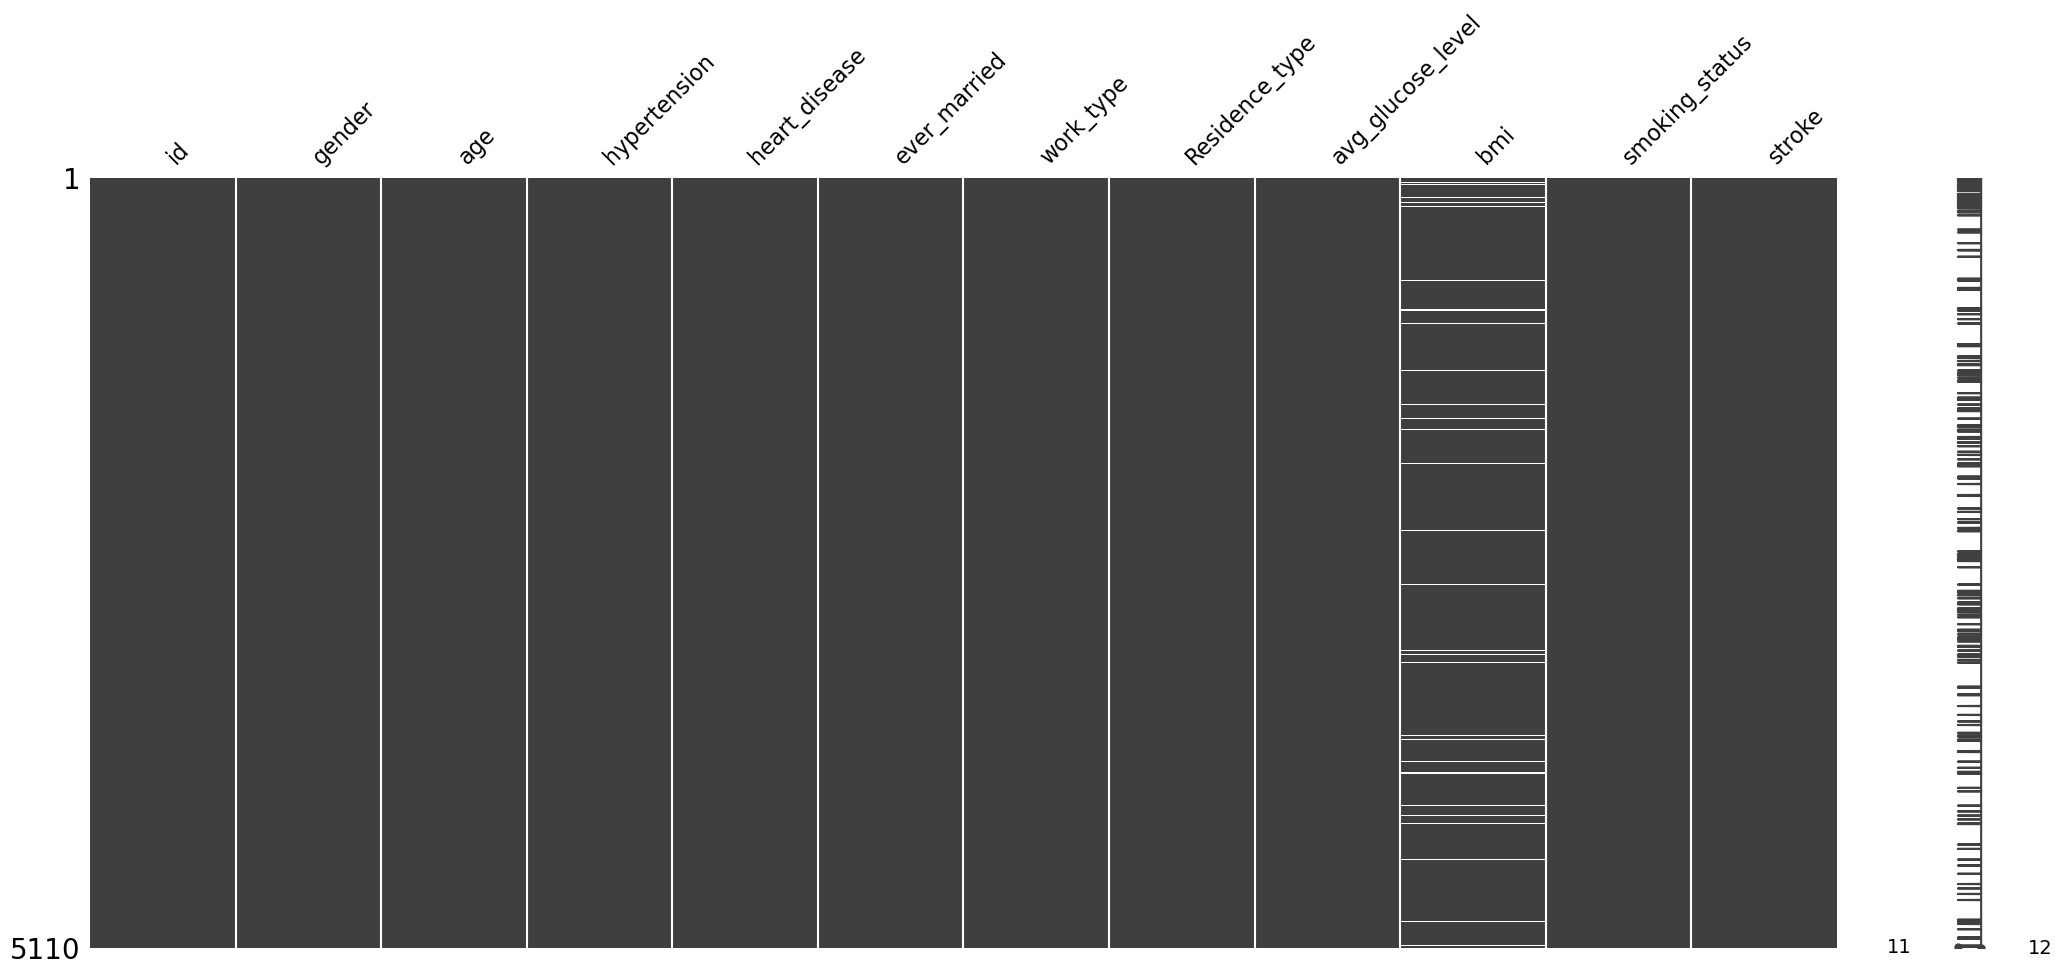

In [196]:
# Visualisation des valeurs manquantes 
msno.matrix(df)

In [197]:
# Vue statistique des variables 
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


.Le tableau renseigne quelques paramètres statistiques des variables à savoir la moyenne, les quartiles, les min et max
.On observe pour certaines variables, des valeurs qui semblent étre loin de la normale mais avec la visualisation, nous 
.saurons confirmer ou pas .  

In [198]:
# Détails des variables catégorielles
df.describe(include=object)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


.Nous observons pour chaque variable catgorielle ses valeurs distinctes et la frèquence .

In [199]:
# Observations des valeurs uniques
for var in df.select_dtypes('object'):
    print(df[var].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


#### Visualisation des données

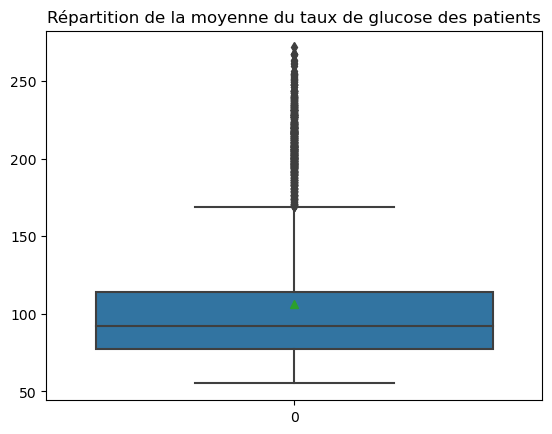

In [200]:
# Visualisation de la variable avg_glucose
sns.boxplot(data=df.avg_glucose_level, showmeans=True)
plt.title('Répartition de la moyenne du taux de glucose des patients')
plt.show()

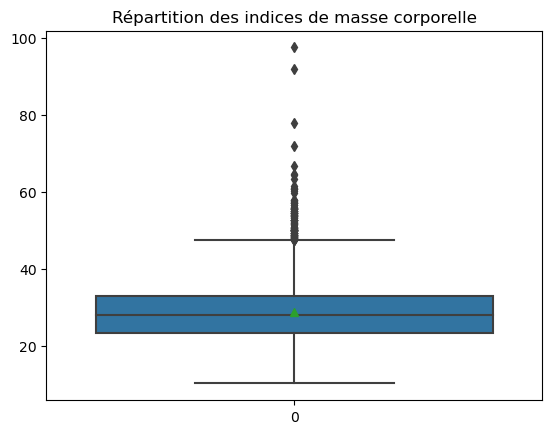

In [201]:
sns.boxplot(data=df.bmi, showmeans=True)
plt.title('Répartition des indices de masse corporelle')
plt.show()

. Pour les boxplots des variables ibm et avg_glucose_level, on voit des valeurs extremes souvent considérées comme
. des outliers.Dans notre cas, on a opté de conserver ces valeurs vu on est en domaine sanitaire qui est sensible.

Text(0.5, 1.0, 'Catégorie du target')

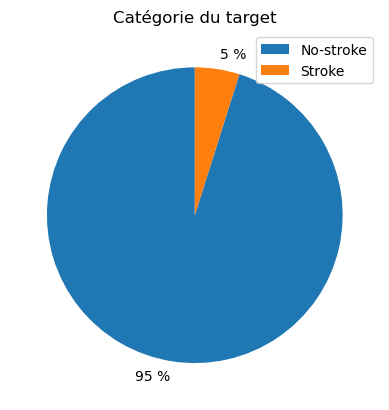

In [202]:
#Répartition du target

labels = [0, 1]
count = [df.stroke.value_counts()[labels[0]], df.stroke.value_counts()[labels[1]]]
perc = [count[0] / (count[0] + count[1]), count[1] / (count[0] + count[1])]

data = [perc[0], perc[1]]

plt.pie(data, startangle = 90, labels = [str(round(perc[0] * 100)) + ' %' , str(round(perc[1] * 100)) + ' %'])
plt.legend(['No-stroke', 'Stroke'])
plt.title("Catégorie du target")

. Dans le dataset, il y a 96% de patients non-atteints d'avc et 4% qui en sont atteints. Le dataset est très déséquilibré.
. On continue de travailler comme tel pour voir ce que çà donne, de l'autre coté, on fait une data augmentation
. espèrant d'avoir des résultats plus pertinents.

Text(0.5, 1.0, "Répartition de l'àge des patients")

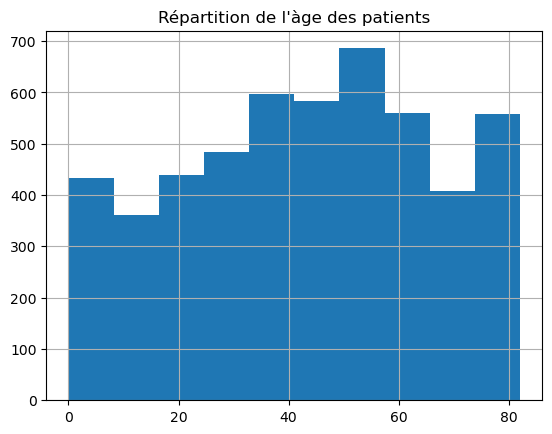

In [203]:
# Visualisation de la varibale àge
df.age.hist()
plt.title('Répartition de l\'àge des patients')

. L'àge des patients est compris entre 0 et 80 ans, ce qui sous-entend qu'il y a des enfants
. on filtrera les patients de sorte à travailler avec un échantillon de patients plus parlant en terme d'àge

Text(0.5, 1.0, 'Répartition des genres des patients')

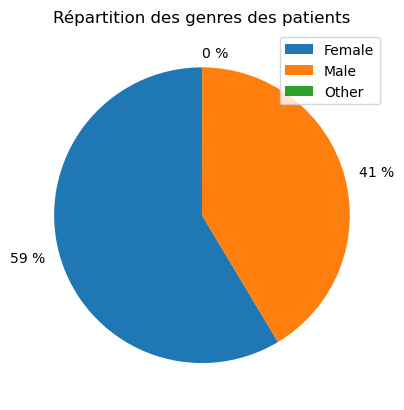

In [207]:
# Visualisation de la variable gender
labels = [0,1,2]
count =[df.gender.value_counts()[labels[0]], df.gender.value_counts()[labels[1]], df.gender.value_counts()[labels[2]]]
perc = [count[0] / (count[0] + count[1] + count[2]), count[1] / (count[0] + count[1] + count[2]), count[2] / (count[0] + count[1]+ count[2]) ]

data = [perc[0], perc[1], perc[2]]

plt.pie(data, startangle = 90, labels = [str(round(perc[0] * 100)) + ' %' , str(round(perc[1] * 100)) + ' %', str(round(perc[2] * 100)) + ' %'])
plt.legend(['Female', 'Male','Other'])
plt.title("Répartition des genres des patients")

. I y a plus de femmes que d'hommes dans le dataset, autre représente des patients non identifiés qui sont négligeable
. en terme de représentativité

Text(0.5, 1.0, 'Répartition des genres des patients')

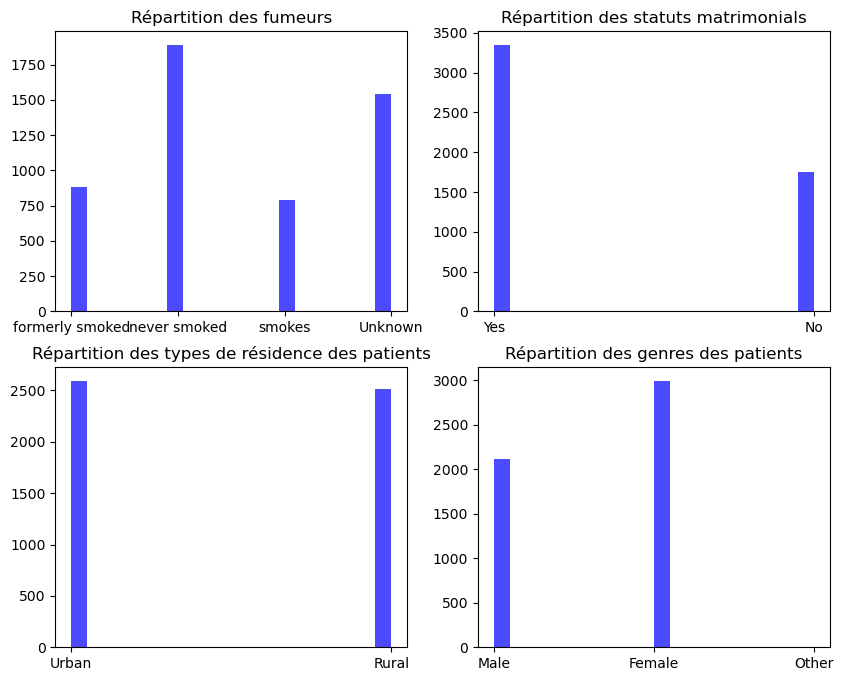

In [208]:
# Visualisation des variables smoking_status, residence_type, ever_married
fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 
axs[0,0].hist(df.smoking_status, bins=20, color='blue', alpha=0.7)
axs[0,0].set_title('Répartition des fumeurs')
#axs[0].set_xlabel('Valeurs')
#axs[0].set_ylabel('Fréquence')

axs[0,1].hist(df.ever_married, bins=20, color='blue', alpha=0.7)
axs[0,1].set_title('Répartition des statuts matrimonials')

axs[1,0].hist(df.Residence_type, bins=20, color='blue', alpha=0.7)
axs[1,0].set_title('Répartition des types de résidence des patients')

axs[1,1].hist(df.gender, bins=20, color='blue', alpha=0.7)
axs[1,1].set_title('Répartition des genres des patients')



. On voit une répartition générale des variables liées au mode de vie.Il y a plus de patients non fumeurs,plus de mariés,
. plus de patients habitant en milieu urbain.

#### Data Processing

. On procède au traitement des données en supprimant certaines variables jugées pas intéressantes pour l'étude,
. les valeurs manquantes si nécessaires , ré-échantilloner le dataset etc...

In [210]:
# suppression de la colonne id
df.drop(columns="id", inplace=True)

In [211]:
# Suppression de "others" dans la variable gender
df.drop(df[df['gender'] == 'Other'].index, inplace=True)

In [212]:
# Supression des valeurs manquantes dans la variable 'bmi'
df.dropna(subset=['bmi'], axis=0, inplace=True)

. Remarquant que certains patients sont des bébés, on travaille avec les patients ayant un age supérieur à 10 ans.

In [213]:
# Filtre des patients supérieurs à 10 ans
df_final = df[df['age'] >= 10]
#df_final

- Data and visualization after the prepocessing

In [214]:
df_final.shape

(4449, 11)

. On se retrouve avec un jeu de donnée de 4449 observations avec 11 variables 

. Analyse finale du jeu de données aprés le traitement

In [145]:
df_final.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000,4449.000000
mean,46.848955,0.101371,0.054394,106.549638,29.928793,0.046977
std,19.775496,0.301853,0.226819,45.802313,7.437747,0.211613
min,10.000000,0.000000,0.000000,55.120000,11.300000,0.000000
25%,31.000000,0.000000,0.000000,77.120000,24.800000,0.000000
50%,48.000000,0.000000,0.000000,91.920000,28.800000,0.000000
75%,62.000000,0.000000,0.000000,114.610000,33.700000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [146]:
df_final.describe(include=object)

,gender,ever_married,work_type,Residence_type,smoking_status
count,4449,4449,4449,4449,4449
unique,2,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2681,3204,2809,2251,1852


Text(0.5, 1.0, 'Répartition des genres des patients aprés traitement des données')

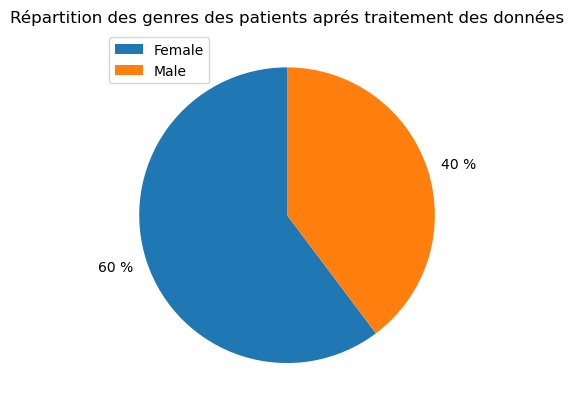

In [147]:
labels = [0, 1]
count = [df_final.gender.value_counts()[labels[0]], df_final.gender.value_counts()[labels[1]]]
perc = [count[0] / (count[0] + count[1]), count[1] / (count[0] + count[1])]

data = [perc[0], perc[1]]

plt.pie(data, startangle = 90, labels = [str(round(perc[0] * 100)) + ' %' , str(round(perc[1] * 100)) + ' %'])
plt.legend(['Female', 'Male'])
plt.title("Répartition des genres des patients aprés traitement des données")

Text(0.5, 1.0, 'Répartition des genres des patients aprés traitement')

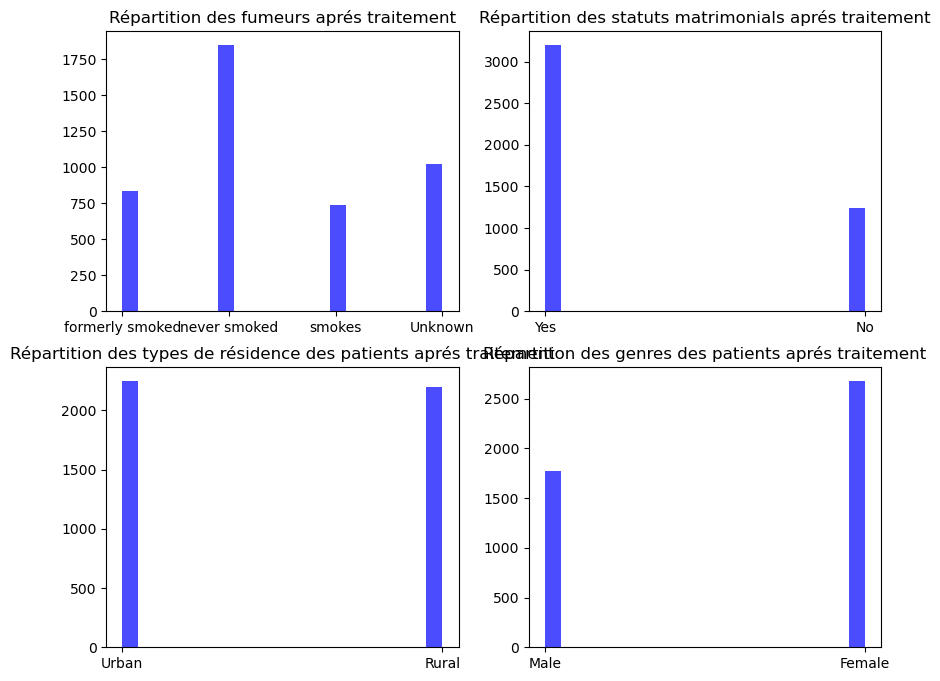

In [148]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 
axs[0,0].hist(df_final.smoking_status, bins=20, color='blue', alpha=0.7)
axs[0,0].set_title('Répartition des fumeurs aprés traitement')
#axs[0].set_xlabel('Valeurs')
#axs[0].set_ylabel('Fréquence')

axs[0,1].hist(df_final.ever_married, bins=20, color='blue', alpha=0.7)
axs[0,1].set_title('Répartition des statuts matrimonials aprés traitement')

axs[1,0].hist(df_final.Residence_type, bins=20, color='blue', alpha=0.7)
axs[1,0].set_title('Répartition des types de résidence des patients aprés traitement')

axs[1,1].hist(df_final.gender, bins=20, color='blue', alpha=0.7)
axs[1,1].set_title('Répartition des genres des patients aprés traitement')


<AxesSubplot:>

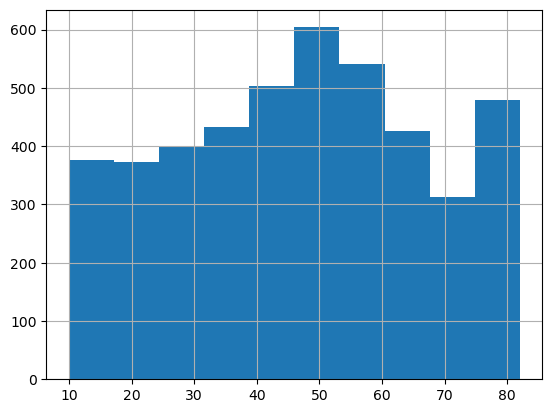

In [149]:
df_final.age.hist()

. Maintenant, l'àge des patients s'étend entre 10 et 80 ans.

### Etude de corrélation entre les variables 

. Ayant des variables de types différents, on choisit cas par cas le type de test qui convient au mieux à la corrélation

In [215]:
# correlation entre bmi et stroke en utilisant Spearman
print("Calcul de la correlation entre bmi et stroke")
correlation, p_value = spearmanr(df_final['bmi'], df_final['stroke'])
print("Coefficient de corrélation de rang de Spearman:", correlation)
print("p-value:", p_value)

Calcul de la correlation entre bmi et stroke
Coefficient de corrélation de rang de Spearman: 0.027898930183348367
p-value: 0.06278360000856376


In [216]:
# correlation entre age et stroke
print("Calcul de la correlation entre age et stroke")
correlation, p_value = spearmanr(df_final['age'], df_final['stroke'])
print("Coefficient de corrélation de rang de Spearman:", correlation)
print("p-value:", p_value)

Calcul de la correlation entre age et stroke
Coefficient de corrélation de rang de Spearman: 0.23332535274937413
p-value: 4.489535326932321e-56


In [217]:
#correlation entre avg_glucose_level et stroke
print("Calcul de la correlation entre avg_glucose_level et stroke")
correlation, p_value = spearmanr(df_final['avg_glucose_level'], df_final['stroke'])
print("Coefficient de corrélation de rang de Spearman:", correlation)
print("p-value:", p_value)

Calcul de la correlation entre avg_glucose_level et stroke
Coefficient de corrélation de rang de Spearman: 0.08870895245551212
p-value: 3.085471682144973e-09


In [220]:
# Test de khi2

# calcul de la correlation entre heart disease (maladie cardiaque) et stroke (AVC)
print("Correlation entre heart disease et stroke:")


# calcul du tableau de contingence
contingency_table = pd.crosstab(df_final['heart_disease'], df_final['stroke'])

#calcul du coeff de contingence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Coefficient de contingence:", np.sqrt(chi2 / (len(df_final['heart_disease']) * min(len(df_final['stroke']), len(df_final['heart_disease'])))))

Correlation entre heart disease et stroke:
Coefficient de contingence: 0.0019754937789457513


In [221]:
#calcul de la correlation entre hypertension (hypertension) et stroke (AVC)
print("Correlation entre hypertension et stroke:")


# calcul du tableau de contingence
contingency_table = pd.crosstab(df_final['hypertension'], df_final['stroke'])

#calcul du coeff de contingence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Coefficient de contingence:", np.sqrt(chi2 / (len(df_final['hypertension']) * min(len(df_final['stroke']), len(df_final['hypertension'])))))

Correlation entre hypertension et stroke:
Coefficient de contingence: 0.0020216996072913956


In [156]:
# calcul de la correlation entre smoking_status (smoking_status) et stroke (AVC)
print("Correlation entre smoking_status et stroke:")
# calcul du tableau de contingence
contingency_table = pd.crosstab(df_final['smoking_status'], df_final['stroke'])

#calcul du coeff de contingence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Coefficient de contingence:", np.sqrt(chi2 / (len(df_final['smoking_status']) * min(len(df_final['stroke']), len(df_final['smoking_status'])))))

Correlation entre smoking_status et stroke:
Coefficient de contingence: 0.0009280314668862633


. Au vue des résultats des différents tests effectués, les coefficients de corrélation entre les variables explicatives et la variable expliquée ne sont pas élevés.Par contre ils sont tous positives, ce qui montre qu'elles évoluent parallèlement avec la variable stroke.Nous choisissons les variables àge et avg_glucose_level dont leur coeffiscient de corrélation est acceptable par rapport aux autres pour faire du machine learning.

In [158]:
#from sklearn.preprocessing import LabelEncoder

#def get_annotation(encoder, variable_name):
#    print(variable_name)
#    for i, category in enumerate(encoder.classes_):
#        print(f"{category}: {i}")



#label_encoder = LabelEncoder()
#df_final['gender'] = label_encoder.fit_transform(df_final['gender'])
#get_annotation(label_encoder, "Gender :")
#print("\n")

#df_final['ever_married'] = label_encoder.fit_transform(df_final['ever_married'])
#get_annotation(label_encoder, 'Ever married :')
#print("\n")

#df_final['work_type'] = label_encoder.fit_transform(df_final['work_type'])
#get_annotation(label_encoder, 'Work type :')
#print("\n")

#df_final['Residence_type'] = label_encoder.fit_transform(df_final['Residence_type'])
#get_annotation(label_encoder, 'Residence type :')
#print("\n")

#df_final['smoking_status'] = label_encoder.fit_transform(df_final['smoking_status'])
#get_annotation(label_encoder, 'Smoking status :')

In [225]:
#Sélection de la variable explicative hypertension
X = df_final[['age']]


# Sélection de la variable expliquée 
y = df_final['stroke']

# Séparation de la donnée en set d'entraînement et de validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [226]:
# Initialisation du modèle 
logreg = LogisticRegression()

In [227]:
# Entrainement, prédiction et score
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic regression model accuracy: {:.2f}'.format(logreg.score (X_test, y_test)))

Logistic regression model accuracy: 0.95


[[848   0]
 [ 42   0]]


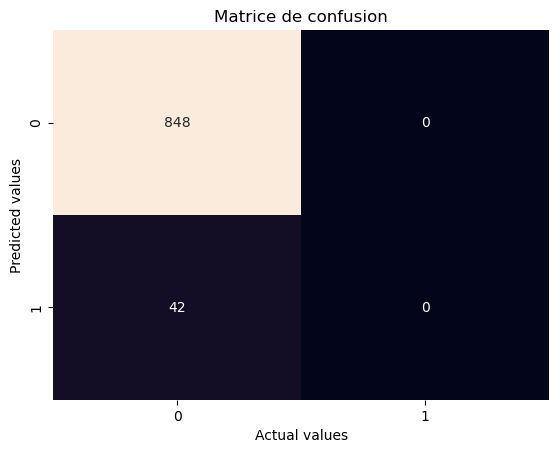

In [228]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cbar=False)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Matrice de confusion')

print(cm)


In [164]:
# rapport de classification
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98       848
           1       0.00      0.00      0.00        42

    accuracy                           0.95       890
   macro avg       0.48      0.50      0.49       890
weighted avg       0.91      0.95      0.93       890



##### Modèliser avec Random Forest

In [229]:
# Initialisation du modèle Classifier 
rf_classifier= RandomForestClassifier()

In [230]:
# Entrainement et prédiction
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

In [231]:
# Mètrique : rapport de classification
print("\nClassification Report:")
report = classification_report(y_test, y_pred_rf)
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       848
           1       0.00      0.00      0.00        42

    accuracy                           0.95       890
   macro avg       0.48      0.50      0.49       890
weighted avg       0.91      0.95      0.93       890



-  Modèliser avec les variables àges et avg_glucose_level

In [232]:
# Définition des variables explicatives ( àge et avg_glucose_level) et de la variable expliquée(stroke) 
X = df_final[['age', 'avg_glucose_level']]
y = df_final['stroke']

In [233]:
# Mise à l'échelle des données (feature scaling)
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

. Mise à l'échelle des features car les variables àge et avg_glucose_level sont d'unité différent mais aussi pour viter 
. que l'une d'elles prenne le dessus dans la modèlisation

In [234]:
# Division des données en set de validation et d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.3, random_state=42)

In [174]:
# initialisation du modèle de la régression logistique 
logreg1 = LogisticRegression()

In [175]:
# Entrainement, prédiction
logreg1.fit(X_train, y_train)
y_pred1 = logreg1.predict(X_test)

print('Logistic regression model accuracy: {:.2f}'.format(logreg1.score (X_test, y_test)))

Logistic regression model accuracy: 0.95


In [176]:
# Metric classification report
#print(classification_report(y_test, y_pred1))